## Probabilistic Principal Component Analysis

In this lab we will use PPCA for dimensionality reduction, we are using a database of handwritten digits as sample dataset. 

We will compare two methods to compute the PPCA, the first one is the EM-algorithm, and the second one is based on the Gibbs Sampling.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
import numpy as np
import scipy as sp
import time

from numpy import random as rd
from scipy import stats

### Loading the dataset

In [2]:
data = []
for i in range(0, 10):
    data.append(np.loadtxt('digits/digit%d.csv' % (i), delimiter=','))

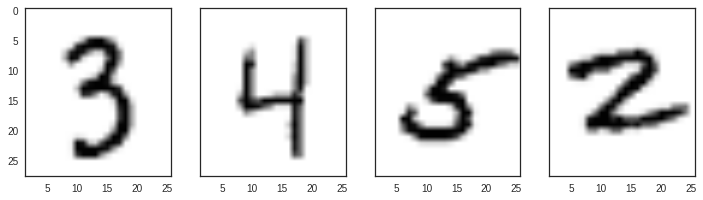

In [3]:
def plot_digit(digit, sample = 0, name = '', ax = None):
    x = digit[sample, :].reshape((28, 28)).T
    ax = ax if ax else plt
    ax.imshow(x)
    
def plot_digits(data, digits, s = 10):
    with sb.axes_style("white"):
        _, ax = plt.subplots(1, len(digits), sharey=True, figsize=(3 * len(digits), 3))
        for i in range(len(digits)):
            j = digits[i]
            plot_digit(data[j], s, 'Sample %d' % j, ax[i])
        plt.show()

plot_digits(data, [3, 4, 5, 2])

### Centering the data

In both algorithms (EM and Gibbs Sampling) is convenient to center the dataset.

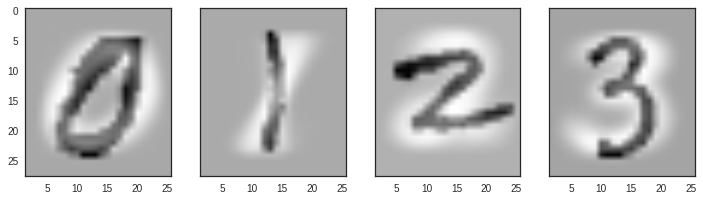

In [4]:
def center_vector(v):
    return v - np.mean(v, axis=0)

cdata = []
for i in range(10):
    cdata.append(center_vector(data[i]))
    
plot_digits(cdata, [0, 1, 2, 3])

### Auxiliary functions

In this section we will describe some auxiliary functions that will be useful in both approaches

#### Recover: Maps from latent space to observable space
    
$$
    \mathbf{x} = \mathbf{Wz} + \mathbf{u} + \epsilon
$$

As $\textbf{z}$ is a latent variable we need to use its expected value that is defined as:
    
$$
    \mathbf{E}[\mathbf{z} \mid \mathbf{x}] = \mathbf{M}^{-1}\mathbf{W}^{\top}(\mathbf{x} - \mathbf{u})
$$

where $\textbf{M} = \textbf{W}^{\top}\textbf{W} + \sigma^{2}\textbf{I}$


#### Project: Maps from observable space to latent space

In that case we can use the result obtained in $\mathbf{E}[\mathbf{z} \mid \mathbf{x}]$

In [5]:
def recover(W_ML, z):
    return W_ML.dot(z)

def calc_M(W, sig):
    return W.T.dot(W) + sig * np.eye(W.shape[1])

def project(x, W, sig):
    M = calc_M(W, sig)
    return np.linalg.pinv(M).dot(W.T).dot(x.T)

def compute_error(A, B):
    return ((A - B) ** 2).mean()

### EM Algorithm

In [6]:
def EM(X, MP, iters = 10): # PPCA for the dataset X, using MP dimentions. MP < D
    st = time.process_time()
    N, D = X.shape
    s2 = 10.0 # initialization
    W = np.ones((D, MP))
    
    for _ in range(iters):
        # E-step
        M = calc_M(W, s2)
        Ez = np.zeros((N, MP))
        Ezz = np.zeros((N, MP, MP))
        for i in range(N):
            Ez[i] = project(X[i], W, s2)
            Ezz[i] = s2 * np.linalg.inv(M) + Ez[i].T.dot(Ez[i])
            
        # M-step
        first = np.zeros((D, MP))
        for i in range(N):
            first += np.outer(X[i], Ez[i])
        second = np.sum(Ezz, axis=0)
        W_new = first.dot(np.linalg.inv(second))
        
        
        acc = 1e-30
        for i in range(N):
            acc = X[i].T.dot(X[i]) - 2.0 * Ez[i].T.dot(W_new.T).dot(X[i])
            acc = acc + np.trace(Ezz[i].dot(W_new.T).dot(W_new))
            
        s2_new = acc / (N * D)
        
        W = W_new
        s2 = s2_new
    print ('\texecution time:', time.process_time() - st, 's')
    return W, s2
        
def run_test(dig, M, pp = False):
    print ('Running EM with digit', dig)
    W, sig = EM(cdata[dig], M)
    m = np.mean(data[dig], axis=0)
    a = project(cdata[dig], W, sig)
    b = recover(W, a).T + m
    print ('\terror(MSE):', compute_error(b, data[dig]))
    return b

def run_tests(d, it, pp = False):
    ans = []
    print ('M = ', it)
    for i in d:
        ans.append(run_test(i, it, pp))
    print('========')
    return ans

In [7]:
data10 = run_tests([0, 1, 3, 6], 10, False)
data30 = run_tests([0, 1, 3, 6], 30, True)

M =  10
Running EM with digit 0
	execution time: 21.102641245999997 s
	error(MSE): 1576.86394629
Running EM with digit 1
	execution time: 20.085375626 s
	error(MSE): 584.231133487
Running EM with digit 3
	execution time: 21.667418143 s
	error(MSE): 1783.44096013
Running EM with digit 6
	execution time: 22.79415680000001 s
	error(MSE): 1537.66463438
M =  30
Running EM with digit 0
	execution time: 57.749972861 s
	error(MSE): 1268.80128041
Running EM with digit 1
	execution time: 51.09489943599999 s
	error(MSE): 800.631564001
Running EM with digit 3
	execution time: 53.55917675500001 s
	error(MSE): 1781.84329869
Running EM with digit 6
	execution time: 54.21993830500003 s
	error(MSE): 1235.81322563


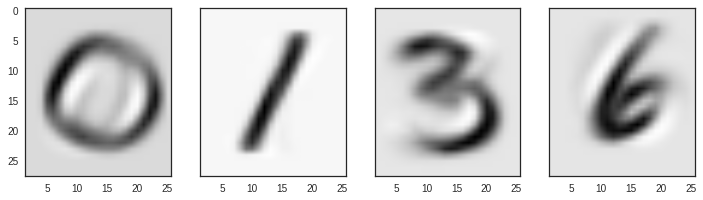

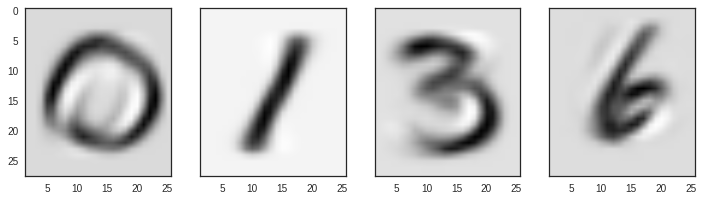

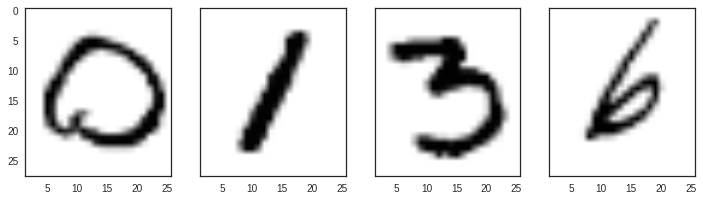

In [8]:
plot_digits(data10, [0, 1, 2, 3], 100)
plot_digits(data30, [0, 1, 2, 3], 100)
plot_digits(data, [0, 1, 3, 6], 100)

-----------

### Gibbs Sampling

#### Model 

$\mathbf{x} = \mathbf{Wz} + \mathbf{\mu} + \epsilon$

where

$\epsilon \sim \mathcal{N}(0, \tau^{-1} \mathbf{I})$

#### Parameters definition

- $\mathbf{W}$ : projection matrix
- $\mathbf{z}$ : latent variable
- $\mathbf{\mu}$ : mean of data
- $\tau$ : precision of data


#### Priors

$p(\mathbf{W} \mid \mathbf{\alpha}) = \prod_{i = 1}^{M} \mathcal{N}(\mathbf{w}_i \mid 0, \alpha_j \mathbf{I})$

$p(\mathbf{z}_n) = \mathcal{N}(\mathbf{z}_n \mid 0, \mathbf{I})$

$p(\mu) = \mathcal{N}(\mu \mid 0, \beta^{-1}\mathbf{I})$

$p(\tau) = Gamma(\tau \mid c_\tau, d_\tau)$

$p(\alpha) = \prod_{i = 1}^{M} Gamma(\alpha_i \mid a_\alpha, d_\alpha)$

#### Hyperparameters

- $\beta$
- $c_\tau$
- $d_\tau$
- $a_\alpha$
- $b_\alpha$

#### Full joint distribution

\begin{aligned}
p(\mathbf{x}, \mathbf{z}, \mathbf{W}, \mathbf{\mu}, \mathbf{\alpha}, \tau) &= p(\mathbf{x} \mid \mathbf{z}, \mathbf{W}, \mathbf{\mu}, \tau) p(\mathbf{z}) p(\mathbf{W} \mid \alpha) p(\mathbf{\mu})  p(\mathbf{\alpha})  p(\tau) \\
p(\mathbf{x} \mid \mathbf{z}, \mathbf{W}, \mathbf{\mu}, \tau) p(\mathbf{z}) & = \prod_{n = 1}^{N} p(\mathbf{x}_n \mid \mathbf{z}_n, \mathbf{W}, \mathbf{\mu}, \tau) p(\mathbf{z}_n) \\
p(\mathbf{x}_n \mid \mathbf{z}_n, \mathbf{W}, \mathbf{\mu}, \tau) & = \mathcal{N}(\mathbf{x}_n \mid \mathbf{W}\mathbf{z}_n + \mathbf{\mu}, \tau^{-1}\mathbf{I})
\end{aligned}

#### Conditional distributions

$
\newcommand{\normXn}{\mathcal{N}(\mathbf{x}_n \mid \mathbf{W}\mathbf{z}_n + \mathbf{\mu}, \tau^{-1}\mathbf{I})}
\newcommand{\postTau}{p(\tau \mid \mathbf{x}_n, \mathbf{z}_n, \mathbf{W}, \mathbf{\mu}, \mathbf{\alpha}, \tau)}
\newcommand{\postAlpha}{p(\alpha \mid \mathbf{x}_n, \mathbf{z}_n, \mathbf{W}, \mathbf{\mu}, \mathbf{\alpha}, \tau)}
$

\begin{align}
\postAlpha & \propto \prod_{i = 1}^{M} p(\mathbf{W} \mid \alpha) p(\alpha) \\
& \propto \prod_{i = 1}^{M} \mathcal{N}(\mathbf{w}_i \mid 0, \alpha_i \mathbf{I}^{-1}) Gamma(\alpha_i \mid a_\alpha, b_\alpha)
\end{align}

The gamma distribution is a conjugate prior for the normal likelihood, then:


$$
p(\alpha_i \mid \mathbf{x}_n, \mathbf{z}_n, \mathbf{W}, \mathbf{\mu}, \mathbf{\alpha}, \tau) \propto Gamma(\alpha_i \mid na_\alpha, nb_\alpha)
$$

Where $na_\alpha = a_\alpha + \frac{D}{2}$ and $nb_\alpha = b_\alpha + \frac{1}{2}\mathbf{w}_{i}^{\top}\mathbf{w}_i$

--- 

\begin{align}
\postTau & \propto \prod_{n = 1}^{N} p(\mathbf{x}_n \mid \mathbf{z}_n, \mathbf{W}, \mathbf{\mu}, \tau) p(\tau) \\
& \normXn Gamma(\tau \mid c_\tau, d_\tau)
\end{align}

The gamma distribution is a conjugate prior for the normal likelihood, then:

$$
\postTau \propto Gamma(\tau \mid nc_\tau, nd_\tau)
$$

$\newcommand{\Xerr}{(\mathbf{x}_n - (\mathbf{W}\mathbf{z}_n + \mu))}$

Where $nc_\tau = c_\tau + \frac{ND}{2}$ and $nd_\tau = d_\tau + \frac{1}{2}(\Xerr^{\top}\Xerr)$

--- 

$\newcommand{postMu}{p(\mu \mid \mathbf{x}_n, \mathbf{z}_n, \mathbf{W}, \mathbf{\mu}, \mathbf{\alpha}, \tau)}$

\begin{align}
\postMu & \propto \prod_{n = 1}^{N} p(\mathbf{x}_n \mid \mathbf{z}_n, \mathbf{W}, \mathbf{\mu}, \tau) p(\mu) \\
& \propto \prod_{n = 1}^{N} \normXn \mathcal{N}(\mu \mid 0, \beta^{-1}\mathbf{I})
\end{align}

Using the equation 2.116 of *1 we can find:

$$
\postMu \propto \mathcal{N}(\mu \mid \mu_\mu, \Sigma_\mu)
$$

Where $\mu_\mu = \tau(\sum_{n = 1}^{N}\mathbf{x}_n - \mathbf{W}\mathbf{z}_n)^{\top}(N\tau + \beta)^{-1}\mathbf{I}$ and $\Sigma_\mu = (N\tau + \beta)^{-1}\mathbf{I}$


--- 

$\newcommand{postW}{p(\mathbf{W} \mid \mathbf{x}_n, \mathbf{z}_n, \mathbf{W}, \mathbf{\mu}, \mathbf{\alpha}, \tau)}$


\begin{align}
\postW & \propto \prod_{n = 1}^{N} p(\mathbf{x}_n \mid \mathbf{z}_n, \mathbf{W}, \mathbf{\mu}, \tau) p(\mathbf{W} \mid \alpha) \\
& \propto \prod_{n = 1}^{N} \normXn \prod_{i = 1}^{M} \mathcal{N}(\mathbf{w}_i \mid 0, \alpha_i \mathbf{I})
\end{align}

In this case is convenient see the conditional for each column:

$$
\normXn = \mathcal{N}(\mathbf{x}_n \mid \mathbf{w}_i \mathbf{z}_{ni} + \mathbf{w}_j \mathbf{z}_{nj} + \mathbf{\mu}, \tau^{-1}\mathbf{I}) \\
\forall_{j} , 0 \le j \le N \land j \ne i
$$

$$
p(\mathbf{w}_i \mid {\mathbf{w}_{j, \forall j \neq i}}, \mathbf{x}_n, \mathbf{z}_n, \mathbf{\mu}, \mathbf{\alpha}, \tau) \propto \mathcal{N}(\mathbf{w}_i \mid \mu_{\mathbf{w}_{ni}}, \Sigma_{\mathbf{w}_{ni}})
$$

Where $\Sigma_{\mathbf{w}_{ni}} = (\alpha_i^{-1}\mathbf{I} + \mathbf{z}_{ni}\tau\mathbf{I}\mathbf{z}_{ni})$ and $\mu_{\mathbf{w}_{ni}} = \Sigma_{\mathbf{w}_{ni}}(\mathbf{z}_{ni}\tau\mathbf{I}(\mathbf{x}_n - \mathbf{b}))$

Note: $\mathbf{b} = \mathbf{w}_{j}\mathbf{z}_{nj} + \mu, \forall j \ne i$

--- 

\begin{align}
p(\mathbf{z}_n \mid \mathbf{x}_n, \mathbf{z}_n, \mathbf{W}, \mathbf{\mu}, \mathbf{\alpha}, \tau) & \propto \prod_{n = 1}^{N} p(\mathbf{x}_n \mid \mathbf{z}_n, \mathbf{W}, \mathbf{\mu}, \tau) p(\mathbf{z}_n) \\
 & \propto  \prod_{n = 1}^{N} \normXn \mathcal{N}(\mathbf{z}_n \mid, 0, \mathbf{I})
\end{align}

Using the equation 2.116 of *1 we can find:

\begin{align}
p(\mathbf{z}_n \mid \mathbf{x}_n, \mathbf{z}_n, \mathbf{W}, \mathbf{\mu}, \mathbf{\alpha}, \tau) & \propto \prod_{n = 1}^{N} \mathcal{N}(\mathbf{z}_n \mid \mathbf{\mu}_{z_n}, \mathbf{\Sigma}_{z_n})
\end{align}

Where $\Sigma_{\mathbf{z}_n} = (\tau \mathbf{W}^{\top}\mathbf{W} + \mathbf{I})^{-1}$ and $\mathbf{\mu}_{\mathbf{z}_n} = \tau\Sigma_{\mathbf{z}_n}(\mathbf{W}^{\top}(\mathbf{x}_n - \mathbf{\mu}))$




*1 : Bishop, Pattern recognition and Machine Learning

In [9]:
class Sampler:
    def __init__(self, D, MP, N):
        self.a_alpha = 1.0
        self.b_alpha = 1.0
        self.a_tau = 1.0
        self.b_tau = 1.0
        self.beta = 0.1
        self.D = D
        self.MP = MP
        self.N = N

    def draw_alpha(_, xn, zn, W, mu, alpha, tau):
        new_alpha = np.zeros(_.MP)
        a = _.a_alpha + _.D / 2.0
        for i in range(_.MP):
            w_i = W[:, i]
            b = w_i.T.dot(w_i) + _.b_alpha
            new_alpha[i] = rd.gamma(a, 1.0 / b)
        return new_alpha
    
    def draw_tau(_, xn, zn, W, mu, alpha, tau):
        a = _.a_tau + _.N * _.D * 0.5
        x = W.dot(zn) + mu
        dist = xn - x
        dist = (dist ** 2).sum()
        b = _.b_tau + 0.5 * dist
        return rd.gamma(a, 1.0 / b)
    
    def draw_mu(_, xn, zn, W, mu, alpha, tau):
        cov = np.eye(_.D) * (1.0 / (_.N * tau + _.beta))
        tmp = W.dot(zn)
        tmp = xn - tmp
        mean = tau * cov
        mean = mean.dot(tmp.sum(axis=1)[:,])
        sample = rd.multivariate_normal(mean.flatten(), cov)
        sample = np.array([sample]).T
        return sample
    
    def draw_W(_, xn, zn, W, mu, alpha, tau):
        for i in range(_.MP):
            first = W.dot(zn) - (xn - mu)
            zin = zn[i,:]
            wi = W[:,i,None]
            ssum = (zin ** 2).sum()
            cov = np.eye(_.D) * (1.0 / (alpha[i] + tau * ssum))
            second = zin * wi
            third = (first - second) * zin
            v = third.sum(axis=1)[:,]
            mean = (-tau * cov).dot(v)
            W[:,i] = rd.multivariate_normal(mean.flatten(), cov)
        return W
    
    
    def draw_zn(_, xn, zn, W, mu, alpha, tau):
        zn_ret = np.zeros(zn.shape)
        cov = (tau * W.T).dot(W) + np.eye(_.MP)
        cov = np.linalg.pinv(cov)
        first = (tau * cov).dot(W.T)
        means = first.dot(xn - mu)
        for i in range(_.N):
            zn_ret[:,i] = rd.multivariate_normal(means[:,i], cov)
        return zn_ret
    
def gibbs_sampling(x, MP, S): # data, MP < D, samples
    st = time.process_time()
    N, D = x.shape
    sampler = Sampler(D, MP, N)
    
    x = x.T
    
    W = np.ones((D, MP))
    mu = np.zeros((D, 1))
    alpha = np.zeros(MP)
    zn = np.zeros((MP, N))
    tau = 0.5
    
    E_W = np.zeros((D, MP))
    E_mu = np.zeros((D, 1))
    E_alpha = np.zeros(MP)
    E_tau = 0.0
    
    for _ in range(S):
        alpha = sampler.draw_alpha(x, zn, W, mu, alpha, tau)
        tau = sampler.draw_tau(x, zn, W, mu, alpha, tau)
        mu = sampler.draw_mu(x, zn, W, mu, alpha, tau)
        W = sampler.draw_W(x, zn, W, mu, alpha, tau)
        zn = sampler.draw_zn(x, zn, W, mu, alpha, tau)
        print ('.', end='')
        E_W += W / S
        E_mu += mu / S
        E_alpha += alpha / S
        E_tau += tau / S
    
    print ('')
    return E_W, E_mu, E_tau, time.process_time() - st

def run_gibbs(digits, M, S):
    cur = []
    for i in digits:
        cur.append(gibbs_sampling(data[i], M, S))
    return cur

ids = [0, 1, 3, 6]
ans10 = run_gibbs(ids, 10, 50)
ans20 = run_gibbs(ids, 30, 50)

..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................
..................................................


M =  10
Running Gibbs with digit 0
	execution time: 872.3489898199999 s
	error(MSE): 1489.5084234
Running Gibbs with digit 1
	execution time: 913.4511040570003 s
	error(MSE): 448.720172288
Running Gibbs with digit 3
	execution time: 906.6673271099999 s
	error(MSE): 1705.83724617
Running Gibbs with digit 6
	execution time: 963.2109812190001 s
	error(MSE): 1378.73870538
M =  50
Running Gibbs with digit 0
	execution time: 3009.3518826120003 s
	error(MSE): 708.575204635
Running Gibbs with digit 1
	execution time: 2847.6290498440003 s
	error(MSE): 209.417400381
Running Gibbs with digit 3
	execution time: 2977.6438194540005 s
	error(MSE): 869.004092999
Running Gibbs with digit 6
	execution time: 3165.97710774 s
	error(MSE): 639.625167367


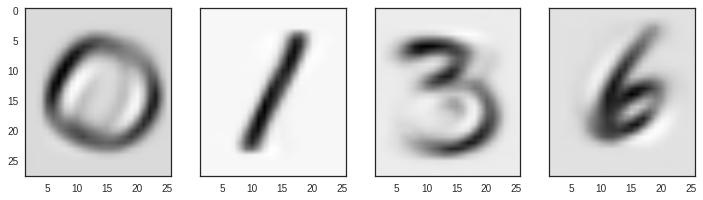

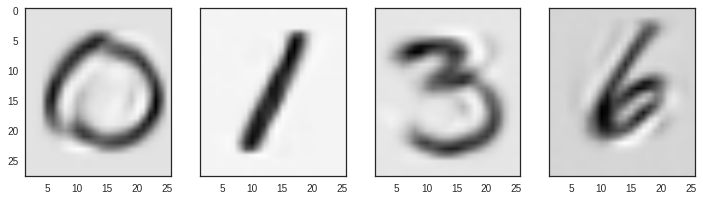

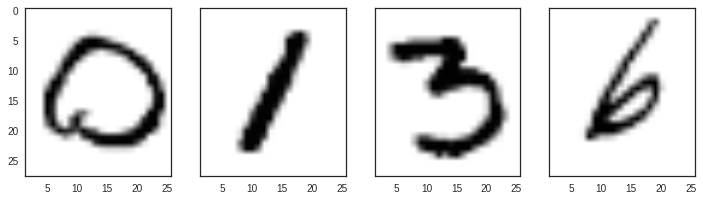

In [10]:
def show_ans(ans, ids, M):
    print ('M = ', M)
    ret = []
    for i in range(len(ans)):
        dig = ids[i]
        print ('Running Gibbs with digit', dig)
        m = np.mean(data[dig], axis=0)
        W, E_mu, E_tau, ex_time = ans[i]
        a = project(cdata[dig], W, 1.0 / E_tau)
        b = recover(W, a).T + m
        ret.append(b)
        print ('\texecution time:', ex_time, 's')
        print ('\terror(MSE):', compute_error(b, data[dig]))
    return ret
        
plot10 = show_ans(ans10, ids, 10)
plot20 = show_ans(ans20, ids, 50)
plot_digits(plot10, [0, 1, 2, 3], 100)
plot_digits(plot20, [0, 1, 2, 3], 100)
plot_digits(data, ids, 100)

#### MSE: 

EM:

|M|0|1|3|6|
|---|-|-|-|-|
|10|1576.86394629|584.231133487|1783.44096013|1537.66463438|
|30|1268.80128041|800.631564001|1781.84329869|1235.81322563|
|ratio|1.2427981990847716|0.7297128414066252|1.000896634087394|1.244253259707688|


Gibbs 50 iterations:

|M|0|1|3|6|
|---|-|-|-|-|
|10|1489.5084234|448.720172288|1705.83724617|1378.73870538|
|30|708.575204635|209.417400381|869.004092999|639.625167367|
|ratio|2.102117620905565|2.142707203277419|1.9629795301458528|2.1555416761594|

#### Times in seconds:

EM:

|M|0|1|3|6|
|---|-|-|-|-|
|10|21.102641245999997|20.085375626|21.667418143|22.79415680000001|
|30|57.749972861|51.09489943599999|53.55917675500001|54.21993830500003|

Gibbs 50 iterations:

|M|0|1|3|6|
|---|-|-|-|-|
|10|872.3489898199999|913.4511040570003|906.6673271099999|963.2109812190001|
|30|3009.3518826120003|2847.6290498440003|2977.6438194540005|3165.97710774|

### Conclusions

- We implemented two different approaches (EM and Gibbs Sampling) to reduce the dimensionality of the images of handwritten digits and we compared them using the mean squared error between the recovered images and the original ones.

- The Gibbs Sampling algorithm leads to better results in terms of the MSE, it also reduces the error when a higher $M$(dimention of new space, $M \ll D$, $D$ is the dimention of the original space) is chosen, this is not so clear in the EM algorithm. However, is significantly slower than the EM algorithm.